<a href="https://colab.research.google.com/github/gogoplodeske/Grading-the-bowl/blob/master/grading_the_the_bowl_echogenicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes: I combined here bothe the offline and onlinr stages. It is possible seperate the offline which is training the 2 models I used (one for the abdomen segmetion and the second for grading) in another folder and save the trained model. And in online we load those trained models and use them for new data.

In [0]:
import os
import cv2 
import numpy as np
from matplotlib import pyplot as plt
from fastai.vision import *
from fastai.metrics import error_rate
from scipy import ndimage, misc

The trainig_set.zip is downloaded from https://zenodo.org/record/1327317#.XtJJFWgzbNw

In [0]:
!unzip training_set.zip

Archive:  training_set.zip
replace training_set/000_HC.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Seperating the images and the annonated images**

In [0]:
listOfFiles = os.listdir('/content/training_set')
for f in listOfFiles:
  img = cv2.imread(os.path.join('/content/training_set',f)) 
  if 'Annotation' in f:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    blur = cv2.blur(gray, (3, 3)) # blur the image
    ret, thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY)
    # cntCon is the contours of componentnt of the image. a component coald be a circle or overlapeed circles
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    hull = []
    # calculate points for each contour
    for i in range(len(contours)):
        # creating convex hull object for each contour
        hull.append(cv2.convexHull(contours[i], False))

    drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
    drawing1 = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
    # draw contours and hull points
    for i in range(len(contours)):
        color_contours = (1, 1, 1) # green - color for contour
        color = (255, 0, 0) # blue - color for convex hull
        # draw ith contour
      
        cv2.drawContours(gray, contours, i, color_contours,-1, 8, hierarchy)
        # draw ith convex hull object
        cv2.drawContours(drawing1, hull, i, color, 1, 8)
        cnt = contours[i]
        hull1 = cv2.convexHull(cnt,returnPoints = False)
    n = f.strip('_Annotation.png')
    n = n+ '.bmp'
    cv2.imwrite(os.path.join('/content/mask',n), gray) 
  else:
     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
     n = f.strip('.png')
     n = n+ '.bmp'
     cv2.imwrite(os.path.join('/content/src',n), gray) 


**Preparing the model for the first stage training to find the abdoment area**

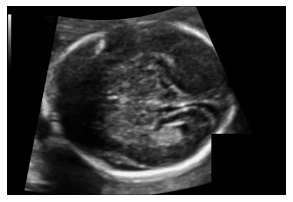

In [0]:
path_lbl = '/content/mask'
path_img = '/content/src'

fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

# open and show image
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [0]:
get_y_fn = lambda x: path_lbl+f'/{x.stem}{x.suffix}'

print(get_y_fn(img_f))

/content/mask/318_HC.bmp


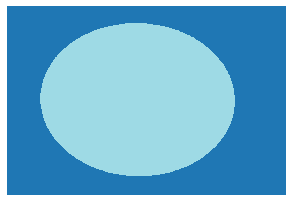

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [0]:
codes = np.array(['Void','1'])

In [0]:
src_size = np.array(mask.shape[1:])
size = src_size//2
bs = 2

src = (SegmentationItemList.from_folder(path_img)
       # Load in x data from folder
       #.split_by_fname_file('../valid.txt')
       .split_by_rand_pct()
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes = codes)
       # Label data using the get_y_fn function
)

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)

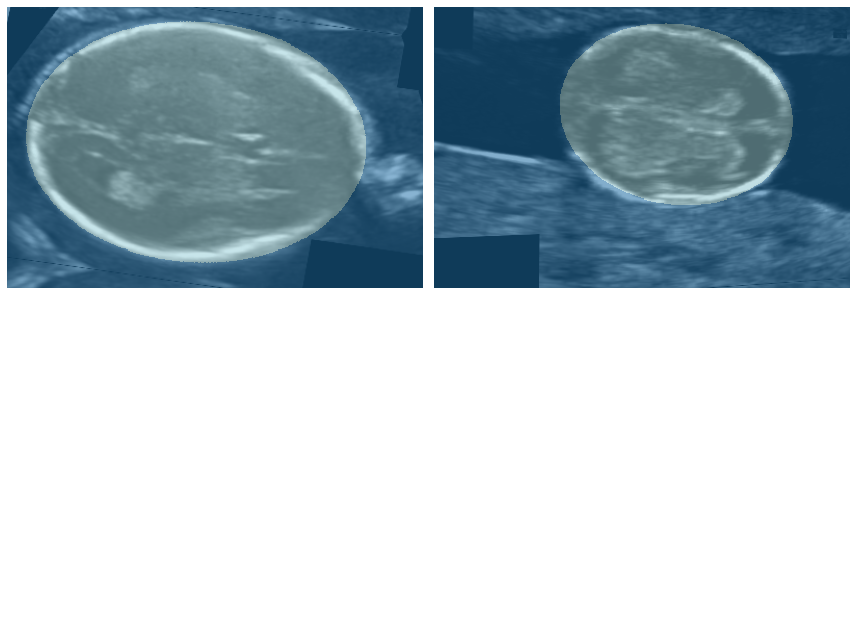

In [0]:
data.show_batch(rows=3, figsize=(12, 9))

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


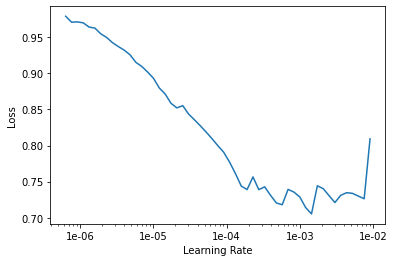

In [0]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [0]:
lr=1e-03

In [0]:
learn.fit_one_cycle(4, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.158188,0.079168,0.960116,03:06
1,0.236690,0.070207,0.965558,03:05
2,0.097313,0.080949,0.970792,03:04
3,0.096032,0.045902,0.970279,03:03


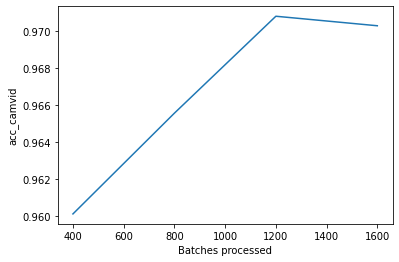

In [0]:
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-1-big')

**after we got the trained model we pass the given data for preprocessing for the next stage which to take the relevant pixels of the bowl**

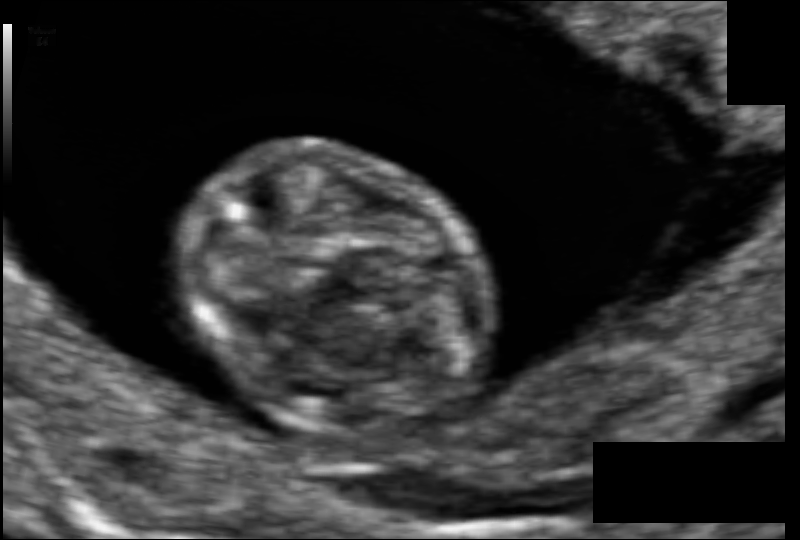

In [0]:
img = open_image('/content/src/004_HC.bmp')


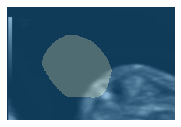

In [0]:
prediction = learn.predict(img)
img.show(y=prediction[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


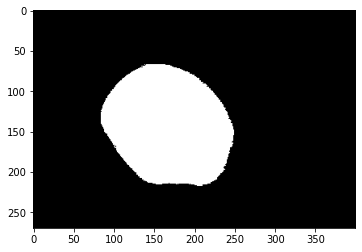

In [0]:
mask = prediction[0].data.numpy()
imgcv = cv2.imread('/content/src/004_HC.bmp')
output = cv2.resize(imgcv, (mask.shape[2],mask.shape[1]))
output= output 
mask3 = np.zeros([mask.shape[1],mask.shape[2],3])
mask3[:,:,0] = mask[0,:,:]
mask3[:,:,1] = mask[0,:,:]
mask3[:,:,2] = mask[0,:,:]
plt.imshow(mask3*output)


In [0]:
abdomen = output*mask3


In [0]:
def getBowl(abdo):
  gray = cv2.cvtColor(abdo, cv2.COLOR_BGR2GRAY) # convert to grayscale
  blur = cv2.blur(gray, (3, 3)) # blur the image
  ret, thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  hull = []
  # calculate points for each contour
  for i in range(len(contours)):
      # creating convex hull object for each contour
      hull.append(cv2.convexHull(contours[i], False))
  areas = [cv2.contourArea(cnt) for cnt in contours]
  if areas:
   j =areas.index(max(areas))
  drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
  drawing1 = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
  # draw contours and hull points
  color_contours = [(1,1,1),(255,255,0),(255,255,255),(0,255,0),(0,255,255),(0,0,250), (50,250,40),(60,10,150),(250,80,10)]
  for i in range(len(contours)):
      #color_contours = (0, 255, 0) # green - color for contour
      color = (255, 0, 0) # blue - color for convex hull
      # draw ith contour
      if i== j:
        cv2.drawContours(drawing, contours, i, color_contours[i],-1, 8, hierarchy)
      # draw ith convex hull object
      cv2.drawContours(drawing1, hull, i, color, 1, 8)
      cnt = contours[i]
      hull1 = cv2.convexHull(cnt,returnPoints = False)
      defects = cv2.convexityDefects(cnt,hull1)

  bowl = drawing*abdo
  inside = abdo[drawing!=0]
  return bowl ,inside


**The bowl contain is the image has the most region which contains th bowl. the inside contians only the values of this region**

In [0]:
#bowl = getBowl(abdomen)
abdomen = np.array(abdomen, dtype=np.uint8)
bowl ,inside  = getBowl(abdomen)

**Here we can see the bowl we got. we save it in a file which we will use later as input to train the model for grading**

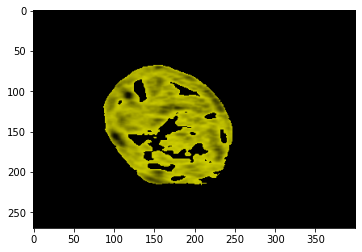

In [0]:
#gray = cv2.cvtColor(abdomen, cv2.COLOR_BGR2GRAY)
plt.imshow(bowl)

In [0]:
cv2.imwrite('/content/traindata/004_HC.png',bowl) 

True

**the inside is the vlause of the bowl we can use for the second solution which is giving grade according to the histogram distribution in this example the grade should be around 2 to  according to the distribution**

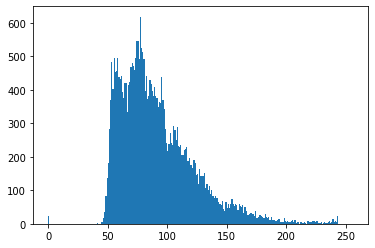

In [0]:
plt.hist(inside.ravel(),256,[0,256]); plt.show()

**After we prepared the data input we can now build and train a model for grading**

In [0]:
#here is the path of the pre-processed images which the bowl we coollect from above 
path = Path('/content/traindata')

In [0]:
classes = ['0','1','2','3','4','5','6']

let's assume that the images file name contains the number of the class i.e. in this form 1_22.png where 1 is the grade label and 22 is the number of image

In [0]:
np.random.seed(42)
pat = r"/(\d)_\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)


In [0]:
learngrade = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learngrade.fit_one_cycle(4)

In [0]:
learngrade.save('stage-2-big')

In [0]:
learngrade.recorder.plot()